# EE 344 — Assignment 4: Fake News Classification

- eeshanis

- 2/13/2026


In this file, I will classify news articles as **fake vs real** using **text features**.
Your tasks for this assignment are as follows:

1. Learn how to extract text features by vectorizing textual inputs using **CountVectorizer (Bag-of-Words)**.
2. Implement **7 classifiers**: Logistic Regression, Perceptron, Linear SVM (LinearSVC), Multinomial Naive Bayes, KNN, Decision Tree, and Random Forest.
3. Evaluate **train and test** performance using **accuracy, precision, recall, and F1-score**.




**Dataset source (for reference only):**  
Do **not** download data from the link below. Use the provided `evaluation.csv` file that comes with this assignment.
#### https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification



## Setup
Run the next cell to import libraries and define helper functions.


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Reproducibility
RANDOM_STATE = 42

def metrics(y_true, y_pred):
    """Return (accuracy, precision, recall, f1)."""
    acc = accuracy_score(y_true, y_pred)

    # Use 'binary' for binary classification, otherwise fallback to macro.
    avg = "binary" if len(np.unique(y_true)) == 2 else "macro"

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=avg, zero_division=0
    )
    return acc, prec, rec, f1


## Load data

Put the dataset file in the same folder as this notebook (recommended), or provide an absolute path.

This dataset uses **semicolon-separated** fields and can contain extra semicolons inside the text.
So we use a custom loader that safely reconstructs the text column.


In [4]:
# === Data path ===
DATA_PATH = "/content/evaluation.csv"

def load_semicolon_dataset(path):
    """
    Handles lines like:
    ;title;text;label
    0;some title;some text that may contain ; ; ; ;0
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        _ = f.readline()  # header
        for line in f:
            line = line.rstrip("\n")
            if not line:
                continue
            parts = line.split(";")
            if len(parts) < 4:
                continue

            idx = parts[0]
            title = parts[1]
            label = parts[-1]
            text = ";".join(parts[2:-1])  # re-join any extra ';' inside text
            rows.append((idx, title, text, label))

    df = pd.DataFrame(rows, columns=["id", "title", "text", "label"])
    df["label"] = pd.to_numeric(df["label"], errors="coerce")
    df = df.dropna(subset=["label"]).reset_index(drop=True)
    df["label"] = df["label"].astype(int)
    return df

df = load_semicolon_dataset(DATA_PATH)
print("Dataset:", df.shape)
print("Label distribution:\n", df["label"].value_counts())

# Combine title + text into one string per document
docs = (df["title"].fillna("") + " " + df["text"].fillna("")).astype(str).tolist()
y = df["label"].values


Dataset: (2788, 4)
Label distribution:
 label
1    1488
0    1300
Name: count, dtype: int64


## Train/test split

We keep a standard **80/20** split with stratification (preserves label ratio).


In [5]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    docs, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train docs:", len(X_train_text), "Test docs:", len(X_test_text))


Train docs: 2230 Test docs: 558


## Case Study: Bag-of-Words Features (CountVectorizer)

We need to convert text into numeric features before we can train ML models.

**CountVectorizer** builds a vocabulary from the **training set** and represents each document as a vector of **counts** (one entry per vocabulary term).

We will use:
$$
\texttt{CountVectorizer(}
\texttt{lowercase=True, stop_words="english", ngram_range=(1,2),}
$$
$$
\texttt{ min_df=2, max_df=0.9, max_features=10000)}
$$

**What each setting means (briefly):**
- `lowercase=True`: convert text to lowercase before building features.
- `stop_words="english"`: remove a predefined list of common English words.
- `ngram_range=(1,2)`: allow 1-word features and 2-word features (bigrams).
- `min_df=2`: keep a term only if it appears in at least 2 training documents.
- `max_df=0.9`: drop a term if it appears in more than 90% of training documents.
- `max_features=10000`: cap the vocabulary size at 10,000 terms (after filtering).

### Tiny example (just to see what it does)

We will build features from 3 short documents and look at the counts.


In [6]:
# CountVectorizer docs (read this once before TODO 1):
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [7]:
toy_docs = [
    "The FAKE news spreads fast",
    "Fake news spreads",
    "Real news spreads",
]

toy_vec = CountVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

toy_X = toy_vec.fit_transform(toy_docs)

print("Toy vocab:", list(toy_vec.get_feature_names_out()))
print("Toy counts (rows = docs):\n", toy_X.toarray())


Toy vocab: ['fake', 'fake news', 'news', 'news spreads', 'spreads']
Toy counts (rows = docs):
 [[1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 1 1]]


## Build Bag-of-Words features

Goal:
1. Create the `CountVectorizer` using the exact settings below.
2. Fit on the training text only.
3. Transform both train and test text into sparse Bag-of-Words features.

Notes:
- `fit_transform` on train, then `transform` on test.
- The output is a **sparse matrix** (CSR). That is normal for text features.


In [8]:
# --- Bag-of-Words settings ---
MAX_FEATURES = 10000
NGRAM_RANGE = (1, 2)

# 1) Create `vectorizer` using CountVectorizer with:
#    lowercase=True
#    stop_words="english"
#    ngram_range=NGRAM_RANGE
#    min_df=2
#    max_df=0.9
#    max_features=MAX_FEATURES
#
# 2) Fit the vectorizer on the training text, then use it to transform:
#    - the training text into BoW features
#    - the test text into BoW features
#
# (Reminder: fit on train only; do NOT fit on test.)
#
# Print the BoW shapes.

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range= NGRAM_RANGE,
    min_df=2,
    max_df=0.9,
    max_features=MAX_FEATURES
)

X_train_bow = vectorizer.fit_transform(X_train_text) #with the X_train text
X_test_bow = vectorizer.transform(X_test_text) #with the X_test text

print("BoW shapes:", X_train_bow.shape, X_test_bow.shape)


BoW shapes: (2230, 10000) (558, 10000)


## Models

Create **7 classifiers** using the exact hyperparameters below.

**Important:** For KNN in this notebook, start with **Euclidean distance**.

Models to implement:
- Logistic Regression: `solver="saga"`, `max_iter=2000`, `n_jobs=-1`, `random_state=42`
- Perceptron: `max_iter=1000`, `tol=1e-3`, `random_state=42`
- SVM (LinearSVC): `random_state=42`
- Naive Bayes (MultinomialNB): `alpha=1.0`
- KNN (Euclidean): `n_neighbors=7`, `metric="euclidean"`, `n_jobs=-1`
- Decision Tree: `max_depth=40`, `random_state=42`
- Random Forest: `n_estimators=300`, `random_state=42`, `n_jobs=-1`

Put them in a dictionary named `models`.


In [9]:
# Build the `models` dictionary using the exact parameters above.

#UNCOMMENT FOR KNN WITH EUCLIDEAN DISTANCE
# models = {
#     "Logistic Regression": LogisticRegression(solver="saga", max_iter=2000, n_jobs=-1, random_state=42),
#     "Perceptron": Perceptron(max_iter=1000, tol=1e-3, random_state=42),
#     "SVM (LinearSVC)": LinearSVC(random_state=42),
#     "Naive Bayes (MultinomialNB)": MultinomialNB(alpha=1.0),
#     "KNN": KNeighborsClassifier(n_neighbors=7, metric="euclidean", n_jobs=-1),
#     "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=40),
#     "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
# }

#KNN COSINE DISTANCE:
models = {
    "Logistic Regression": LogisticRegression(solver="saga", max_iter=2000, n_jobs=-1, random_state=42),
    "Perceptron": Perceptron(max_iter=1000, tol=1e-3, random_state=42),
    "SVM (LinearSVC)": LinearSVC(random_state=42),
    "Naive Bayes (MultinomialNB)": MultinomialNB(alpha=1.0),
    "KNN_cos": KNeighborsClassifier(n_neighbors=7, metric="cosine", n_jobs=-1, algorithm="brute"),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=40),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
}

models


{'Logistic Regression': LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42, solver='saga'),
 'Perceptron': Perceptron(random_state=42),
 'SVM (LinearSVC)': LinearSVC(random_state=42),
 'Naive Bayes (MultinomialNB)': MultinomialNB(),
 'KNN_cos': KNeighborsClassifier(algorithm='brute', metric='cosine', n_jobs=-1,
                      n_neighbors=7),
 'Decision Tree': DecisionTreeClassifier(max_depth=40, random_state=42),
 'Random Forest': RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)}

## Train + evaluate

We will evaluate each model on:
- **Training set**
- **Test set**

Metrics:
- Accuracy
- Precision
- Recall
- F1

We will print a table sorted by **Test F1**.


In [10]:
# Write a loop that:
# 1) fits each model on X_train_bow, y_train ***********
# 2) predicts on train and test
# 3) computes (acc, prec, rec, f1) using metrics(...)
# 4) stores results in a list
# 5) prints a DataFrame sorted by Test F1 (descending)
#
# Use the exact column names below.
from sklearn.pipeline import Pipeline
results = []

best = {"name": None, "pipe": None, "test_f1": -1.0}

for name, clf in models.items():

    clf.fit(X_train_bow, y_train)

    yhat_tr = clf.predict(X_train_bow)
    yhat_te = clf.predict(X_test_bow)

    tr = metrics(y_train, yhat_tr)
    te = metrics(y_test, yhat_te)

    results.append([name, *tr, *te])

    if te[3] > best["test_f1"]:
        best["name"] = name
        best["model"] = clf
        best["test_f1"] = te[3]

cols = [
    "Model",
    "Train Acc", "Train Prec", "Train Rec", "Train F1",
    "Test Acc", "Test Prec", "Test Rec", "Test F1",
]

out = pd.DataFrame(results, columns=cols).sort_values("Test F1", ascending=False).reset_index(drop=True)

pd.set_option("display.max_colwidth", 80)
print("\n=== Results (sorted by Test F1) ===")
print(out.to_string(index=False, formatters={
    "Train Acc": "{:.4f}".format,
    "Train Prec": "{:.4f}".format,
    "Train Rec": "{:.4f}".format,
    "Train F1": "{:.4f}".format,
    "Test Acc": "{:.4f}".format,
    "Test Prec": "{:.4f}".format,
    "Test Rec": "{:.4f}".format,
    "Test F1": "{:.4f}".format,
}))



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== Results (sorted by Test F1) ===
                      Model Train Acc Train Prec Train Rec Train F1 Test Acc Test Prec Test Rec Test F1
              Random Forest    1.0000     1.0000    1.0000   1.0000   0.9892    0.9834   0.9966  0.9900
        Logistic Regression    0.9973     0.9992    0.9958   0.9975   0.9839    0.9738   0.9966  0.9851
              Decision Tree    1.0000     1.0000    1.0000   1.0000   0.9803    0.9832   0.9799  0.9815
            SVM (LinearSVC)    1.0000     1.0000    1.0000   1.0000   0.9749    0.9671   0.9866  0.9767
                 Perceptron    1.0000     1.0000    1.0000   1.0000   0.9659    0.9729   0.9631  0.9680
Naive Bayes (MultinomialNB)    0.9700     0.9779    0.9655   0.9717   0.9516    0.9532   0.9564  0.9548
                    KNN_cos    0.9108     0.8673    0.9832   0.9216   0.8638    0.8066   0.9799  0.8848


### Metrics with KNN - Euclidian Distance:
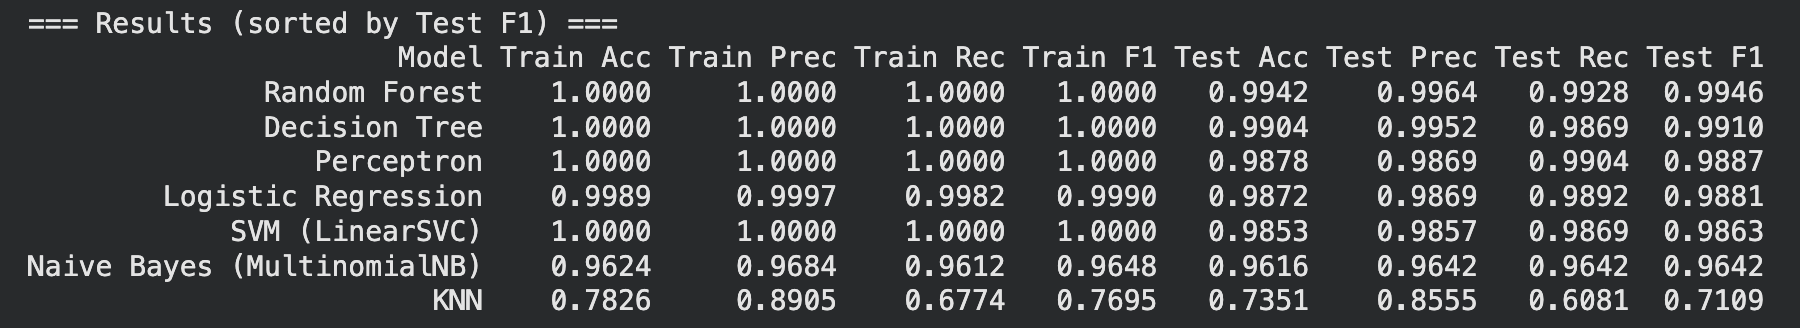

### Metrics with KNN - Cosine Distance:
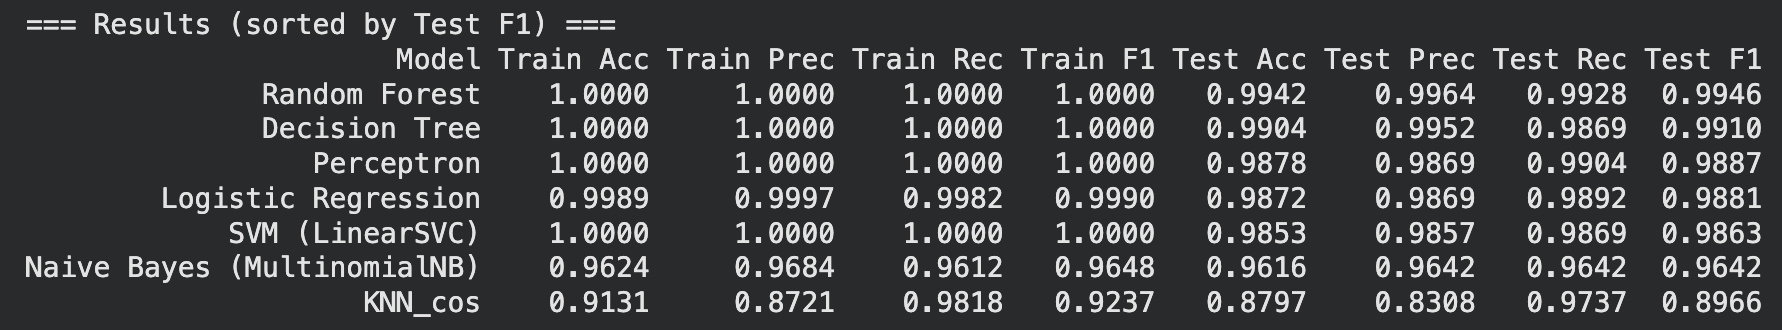

## Cosine distance for KNN

With Bag-of-Words, each document becomes a long vector of word counts (mostly zeros).  
To compare two documents, we need a way to measure how “close” two vectors are.

Two common choices:

- **Euclidean distance**: straight-line distance between two vectors.
- **Cosine distance**: based on the angle between two vectors (uses cosine similarity under the hood).

In scikit-learn, KNN uses a **distance**. Cosine distance is:
$$
d_{\text{cosine}}(x, z) \;=\; 1 - \cos(x, z)
\;=\; 1 - \frac{x^\top z}{\|x\|_2 \,\|z\|_2}
$$

(where $\cos(x,z)$ is cosine similarity).

### Tiny numeric example (no text, just vectors)

Let:
- $x = [1, 1]$
- $z_1 = [2, 2]$  (same direction as $x$, just “bigger”)
- $z_2 = [2, 0]$  (different direction)

**Euclidean distances**
$$
\|x - z_1\|_2 = \sqrt{(1-2)^2 + (1-2)^2} = \sqrt{2}
$$
$$
\|x - z_2\|_2 = \sqrt{(1-2)^2 + (1-0)^2} = \sqrt{2}
$$
So Euclidean says $z_1$ and $z_2$ are equally far from $x$ here.

**Cosine distances**
$$
\cos(x, z_1) = \frac{1\cdot 2 + 1\cdot 2}{\sqrt{2}\cdot \sqrt{8}} = 1
\Rightarrow d_{\text{cosine}}(x, z_1)=0
$$
$$
\cos(x, z_2) = \frac{1\cdot 2 + 1\cdot 0}{\sqrt{2}\cdot 2} \approx 0.707
\Rightarrow d_{\text{cosine}}(x, z_2)\approx 0.293
$$
So cosine says $z_1$ is closer to $x$ than $z_2$.

### What you will do

Keep everything the same, but change your KNN metric from `"euclidean"` to `"cosine"`, then re-run your evaluation and compare results.


In [11]:
# Tip: For cosine distance, brute-force search is commonly used.
# Example (do not run until TODO 2/3 are done):

# knn_cos = KNeighborsClassifier(
#     n_neighbors=7,
#     metric="cosine",
#     algorithm="brute",
#     n_jobs=-1
# )

#I added knn_cos into the list of models. This means there are
#two types of models dictionaries you can use. You can use this by uncommenting one of the
#models dictionaries and rerunning the file based off that dictionary.

## Discussion questions (answer in your own words)

Write short answers below (2–5 sentences each is enough).

### Question A
In your own words, what is the added value of allowing 2-word sequences (bigrams) in `ngram_range`?

### Question B
In your own words, why might someone choose to set both `min_df` and `max_df` when building the vocabulary?

### Question C

After you run KNN with **Euclidean** and then with **Cosine** distance:

- Do you observe any difference in results?
- If yes, why do you think the difference happens (your intuition)?



**Your answers:**

- **A:**  
  Bigrams add more semantic context in the vocabulary dataset. If you had the term "office hours", using an n_gram range of just 1 word would split this up into "office" and "hour". This reduces the semantic context and would skew your model especially if you had the term office hours used in your data as well as "office" and "hour" used separately. To be able to distinguish this, using bigrams would add the additional context / dimension of "office hours" adding more semantic context to the model.

- **B:**  
  Someone might choose to set min_df and max_df when building the vocabulary if they know they have repeating words a lot in their dataset (like "this", "the" etc...). They would need to filter those out with max_df since they don't add much semantically to the vocabulary set. Similarly, if they want to get an overarching theme, they don't need very rare words (like if a word only occurs once), it might skew their vocabulary. In this case, they can use min_df to get rid of these rare words.

- **C:**  
  a. Do you observe any difference in results?

  Yes, there is a difference in results. The cosine distance model showed significant improvement in classification based off test F1 (0.8966) as compared to the euclidian distance test F1 of 0.7109. The overfitting also seems to be reduced because the gap between test F1 and train F1 is smaller with the cosine distance model. In the cosine distance model the distance between train and test F1 is 0.0271 and the euclidian distance has a difference between train and test F1 of 0.0586.

  b. Why do you think the difference happens?

  I think this has to do with sparsity of the BOW dataset. The BOW dataset is very sparse with vectors that have lots of 0s. With euclidian distance, this means that the distances between most vectors span across multiple dimensions which can lead to very similar results distance wise. Whereas, if you take the angles between these vectors, there are more multidimensional relationships extracted since the angles of sparse vectors are more likely to be different from each other. Sentences like "Cat is here" ([1, 1, 1, 0]) and "Cat is there" ([1, 1, 0, 1]) are more likely to be captured as different and closer semantically with cosine (0.333) than euclidean distances (root 2 ~= 1.414).